In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/archive.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/dataset')
  print('Done')

In [ ]:
!nvidia-smi

Sun Feb 23 19:16:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q -U ultralytics
!pip install -U -q ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.0/112.6 GB disk)


In [ ]:
import os
import random
import glob
import shutil

import json
import yaml

from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from lxml import etree as ET

import pandas as pd
import matplotlib.pyplot as plt

import cv2
# from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = "/content/dataset/LogoDet-3K"
# dataset_dir = "/home/sinewave/logocode_detection/datasets/LogoDet-3K"
os.listdir(dataset_dir)

['Leisure',
 'Medical',
 'Others',
 'Necessities',
 'Clothes',
 'Electronic',
 'Food',
 'Transportation',
 'Sports']

In [ ]:
df = pd.DataFrame(glob.glob(f"{dataset_dir}/*/*/*"), columns=["file_path"])
df["ext"] = df["file_path"].apply(lambda x: x.split(".")[-1])
df["logo_category"] = df["file_path"].apply(lambda x: x.split(os.sep)[-3])
df["logo_name"] = df["file_path"].apply(lambda x: x.split(os.sep)[-2])
df.head()

,file_path,ext,logo_category,logo_name
0,/content/dataset/LogoDet-3K/Leisure/mohawk-1/3...,xml,Leisure,mohawk-1
1,/content/dataset/LogoDet-3K/Leisure/mohawk-1/6...,xml,Leisure,mohawk-1
2,/content/dataset/LogoDet-3K/Leisure/mohawk-1/4...,xml,Leisure,mohawk-1
3,/content/dataset/LogoDet-3K/Leisure/mohawk-1/9...,xml,Leisure,mohawk-1
4,/content/dataset/LogoDet-3K/Leisure/mohawk-1/3...,xml,Leisure,mohawk-1


In [ ]:
df.to_csv("logodet3k_reference.csv", index=False)

In [ ]:
df["ext"].value_counts()

,count
ext,
xml,158654
jpg,158654


In [ ]:
df2 = df[df["ext"]=="jpg"].iloc[:]
print({
    "No. of categories": df2["logo_category"].nunique(),
    "No. of logo types": df2["logo_name"].nunique(),
    "Avg. no. of images per category": df2.groupby("logo_category")["file_path"].count().mean().round(),
    "Avg. no. of images per logo": df2.groupby("logo_name")["file_path"].count().mean().round(),
})

{'No. of categories': 9, 'No. of logo types': 3000, 'Avg. no. of images per category': 17628.0, 'Avg. no. of images per logo': 53.0}


In [ ]:
df2["logo_category"].value_counts()

,count
logo_category,
Food,53350
Clothes,31266
Necessities,24822
Others,15513
Transportation,10445
Electronic,9675
Leisure,5685
Sports,3953
Medical,3945


<Axes: title={'center': 'Distribution of logo img counts'}, xlabel='logo_name'>

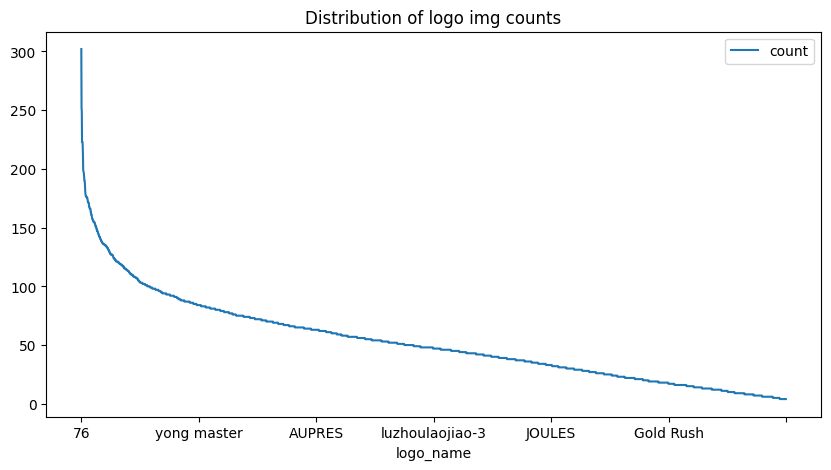

In [ ]:
df2["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

In [ ]:
dataset_dst_dir = "/content/dataset"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)

classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(df2["logo_name"].unique()))}
print(str(classname2idx)[:100]+"...")
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

classname2idx = {"logo": 0}
idx2classname = defaultdict(lambda: "logo")

class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
print(class_name_idx_map_str)

dataset_config = f"""
path: {dataset_dst_dir}
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""
print(dataset_config)
with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
print("-"*10)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)
    print(datcon)

{'10 Cane': 0, '1519 Tequila': 1, '241 Pizza': 2, '2XU': 3, '2xist': 4, '3D-GOLD': 5, '3nod': 6, '3t...
    0: logo

path: /content/dataset 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
    0: logo

----------
{'path': '/content/dataset', 'train': ['train'], 'val': ['val'], 'names': {0: 'logo'}}


In [ ]:
def convert_voc_to_yolo(src, dst, classname2idx):
    tree = ET.parse(src)
    root = tree.getroot()
    yolo_lines = []
    image_width = float(root.find("size/width").text)
    image_height = float(root.find("size/height").text)
    depth = float(root.find("size/depth").text)
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        class_index = classname2idx.get(class_name, 0)
#         yolo_line = f"{class_index} {round(x_center, 6)} {round(y_center, 6)} {round(width, 6)} {round(height, 6)}"
        yolo_line = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_lines.append(yolo_line)
    if dst is not None:
        with open(dst, "w") as f:
            f.write("\n".join(yolo_lines))
    return yolo_lines

convert_voc_to_yolo(f"{dataset_dir}/Clothes/2xist/1.xml", None, {})

['0 0.7592975206611571 0.42689295039164493 0.378099173553719 0.10704960835509138']

In [ ]:
df2['is_train'] = True
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=101)
test_df['is_train'] = False
final_df = pd.concat([train_df, test_df])
final_df.reset_index(drop=True, inplace=True)

def copy_to_working(x):
    train_folder = "train" if x["is_train"] else "val"
    src = x["file_path"]
    dst = os.path.join(dataset_dst_dir, train_folder, "__".join(x["file_path"].split(os.sep)[-3:]))
    if not os.path.exists(dst):
        shutil.copy(src, dst)
    if not os.path.exists(dst.replace(".jpg", ".txt")):
        convert_voc_to_yolo(src.replace(".jpg", ".xml"), dst.replace(".jpg", ".txt"), classname2idx)
    return True

# copy_to_working(final_df.iloc[0].T.to_dict())
copy_to_working_results = []

with ThreadPoolExecutor() as e:
    for _, row in tqdm(final_df.iterrows()):
        status = e.submit(copy_to_working, dict(row))
        copy_to_working_results.append(status)

copy_to_working_results = final_df.apply(lambda x: copy_to_working(x), axis=1)
copy_to_working_results.sum(), final_df.shape[0]

158654it [00:16, 9784.72it/s] 


(158654, 158654)

In [ ]:
model = YOLO('/content/yolo11n.pt')
# model = YOLO('yolov8x.pt')

In [ ]:
def plot_bboxes(r):
    annotator = Annotator(r.orig_img)
    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    img = annotator.result()
    return img

In [ ]:
!wget -O person.jpg https://www.indiafilings.com/learn/wp-content/uploads/2023/03/Can-a-single-person-own-a-firm-in-India.jpg

--2025-02-23 19:25:37--  https://www.indiafilings.com/learn/wp-content/uploads/2023/03/Can-a-single-person-own-a-firm-in-India.jpg
Resolving www.indiafilings.com (www.indiafilings.com)... 104.17.65.1, 104.17.66.1, 2606:4700::6811:4201, ...
Connecting to www.indiafilings.com (www.indiafilings.com)|104.17.65.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33356 (33K) [image/jpeg]
Saving to: ‘person.jpg’

person.jpg          100%[===================>]  32.57K  --.-KB/s    in 0.006s  

2025-02-23 19:25:37 (5.29 MB/s) - ‘person.jpg’ saved [33356/33356]




image 1/1 /content/person.jpg: 448x640 1 person, 44.0ms
Speed: 20.2ms preprocess, 44.0ms inference, 374.1ms postprocess per image at shape (1, 3, 448, 640)


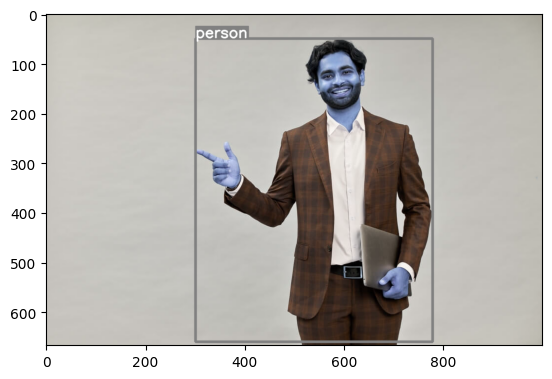

In [ ]:
plt.imshow(plot_bboxes(model("person.jpg")[0]))
plt.show()


0: 640x640 (no detections), 6.0ms
1: 640x640 (no detections), 6.0ms
2: 640x640 1 fork, 3 bowls, 6.0ms
3: 640x640 1 cup, 6.0ms
4: 640x640 1 scissors, 6.0ms
5: 640x640 1 clock, 6.0ms
6: 640x640 (no detections), 6.0ms
7: 640x640 1 knife, 1 pizza, 1 dining table, 6.0ms
8: 640x640 (no detections), 6.0ms
9: 640x640 1 bottle, 6.0ms
Speed: 4.7ms preprocess, 6.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
10


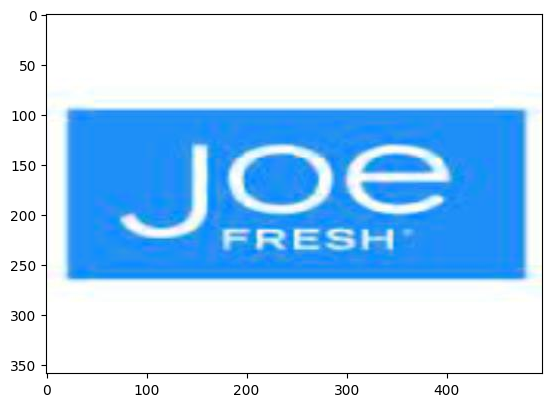

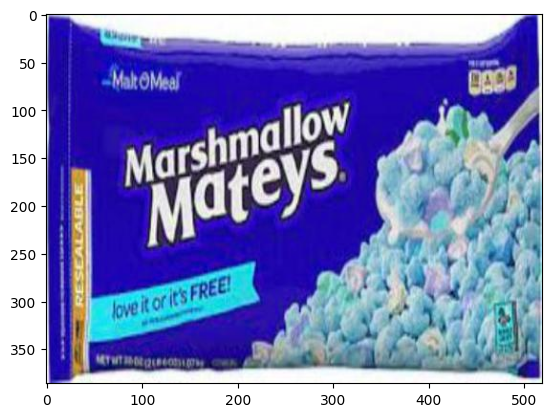

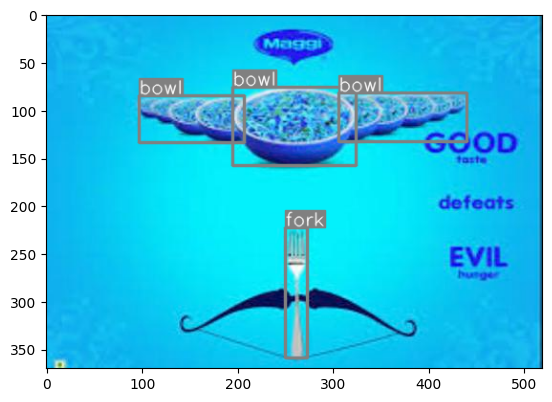

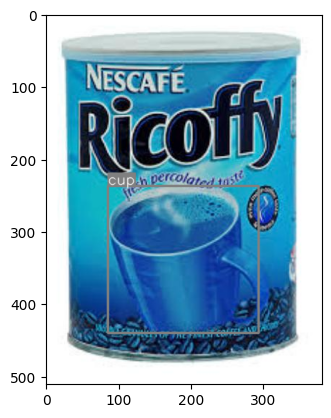

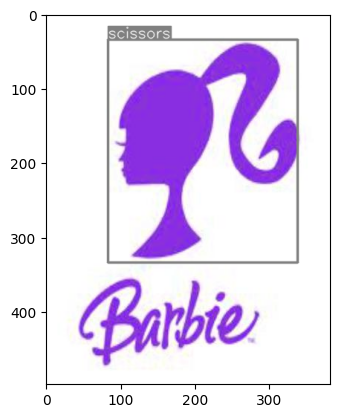

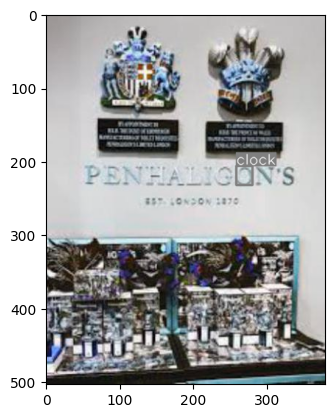

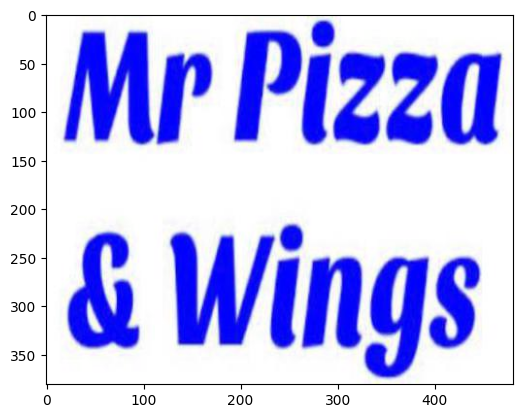

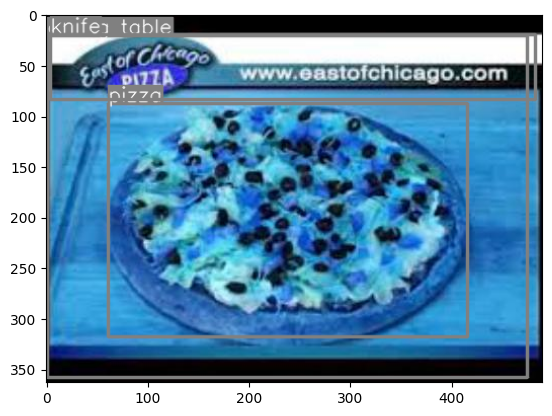

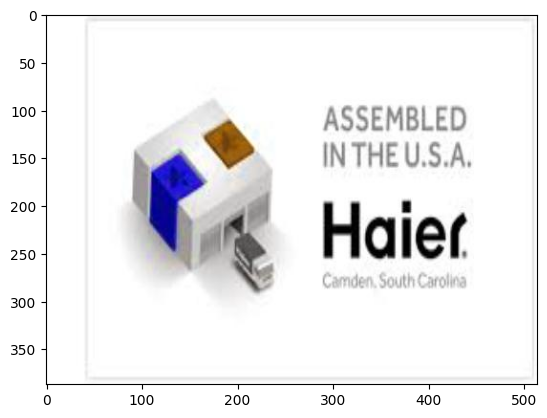

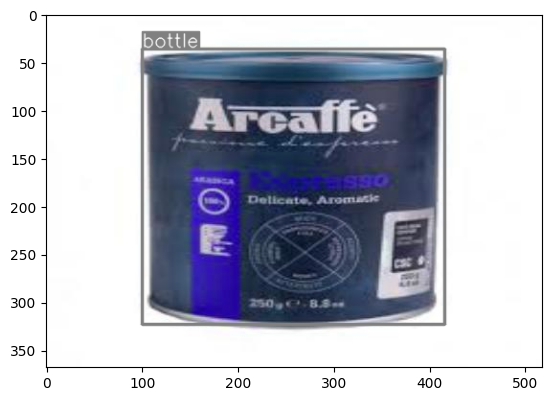

In [ ]:
logos_sample = list(df2.sample(10).T.to_dict().values())
results = model([logo["file_path"]for logo in logos_sample])
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()

In [ ]:
test_results = model.train(data='dataset_config.yaml', epochs=3)
#, cache=True) # dont turn cache true it will run out of memory
print(test_results)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolo11n.pt, data=dataset_config.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/dataset/train.cache... 126923 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126923/126923 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/Food__violet crumble__5.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val.cache... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.59G      1.499      1.706      1.545         28        640: 100%|██████████| 7933/7933 [41:36<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [04:01<00:00,  4.11it/s]


                   all      31731      38866      0.594      0.608      0.616      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.46G      1.311      1.425      1.391         27        640: 100%|██████████| 7933/7933 [41:43<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [04:04<00:00,  4.06it/s]


                   all      31731      38866      0.625      0.647      0.662      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.44G      1.253       1.35      1.349         32        640: 100%|██████████| 7933/7933 [40:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [03:58<00:00,  4.15it/s]


                   all      31731      38866      0.649      0.669      0.689      0.425

3 epochs completed in 2.272 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [03:59<00:00,  4.14it/s]


                   all      31731      38866      0.649      0.669      0.689      0.425
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788ac11ad490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033

In [ ]:
val_results = model.val()
print(val_results)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/dataset/val.cache... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1984/1984 [04:37<00:00,  7.15it/s]


                   all      31731      38866      0.649      0.669      0.689      0.425
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train22
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788ac0f3ab90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03

In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    """Zips a folder and its contents into a zip file.

    Args:
        folder_path (str): The path to the folder to zip.
        output_path (str): The path to the output zip file.
    """

    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)  # Preserve folder structure
                zipf.write(file_path, arcname)

    print(f"Folder '{folder_path}' zipped to '{output_path}'")

# Example usage:
folder_to_zip = '/content/dataset'  # Replace with the actual folder path
output_zip_file = '/content/dataset.zip'  # Replace with the desired output path
zip_folder(folder_to_zip, output_zip_file)